# Extraction

Let's look into html first

In [1]:
# Scrapping data from https://www.bbc.com/weather/293397

# Import libraries
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import time


# Set Chrome options
options = webdriver.ChromeOptions()
options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36")
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument('--window-position=-10000,0')  # Move window off-screen

# Initialize WebDriver
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# Open the URL
url = 'https://www.bbc.com/weather/293397'
driver.get(url)

# Scroll the whole page
last_height = driver.execute_script("return document.body.scrollHeight")

n_scrolls = 1
while True:
    print(f'Making scroll {n_scrolls}')
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)  # Wait for new content to load
    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        break
    last_height = new_height
    n_scrolls += 1

# Get the page source and parse it with BeautifulSoup
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')

print(soup.prettify())

# Close the driver
driver.quit()


Making scroll 1
Making scroll 2
<html class="b-reith-sans-font b-pw-1280 no-touch wr-enhanced wr-svg id-svg b-reith-sans-loaded bbcdotcom" data-location-id="293397" data-location-name="Tel%20Aviv" data-wr-unit--temperature="c" data-wr-unit--windspeed="mph" id="weather-forecast" lang="en">
 <head>
  <meta content="width=device-width, initial-scale=1, user-scalable=1" name="viewport"/>
  <meta charset="utf-8"/>
  <meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
  <meta content="on" http-equiv="cleartype"/>
  <link href="https://ssl.bbc.co.uk/" rel="dns-prefetch"/>
  <link href="http://sa.bbc.co.uk/" rel="dns-prefetch"/>
  <link href="http://ichef-1.bbci.co.uk/" rel="dns-prefetch"/>
  <link href="http://ichef.bbci.co.uk/" rel="dns-prefetch"/>
  <style>
   [data-wr-unit--temperature="c"] .wr-c-map__temperature-f,
        [data-wr-unit--temperature="f"] .wr-c-map__temperature-c,
        [data-wr-unit--windspeed="mph"] .wr-c-map__wind-kph,
        [data-wr-unit--windspeed="kph

Ok, we've succesfully loaded page. Now we can proceed with parsing necessary data.
We'll extract data from this block
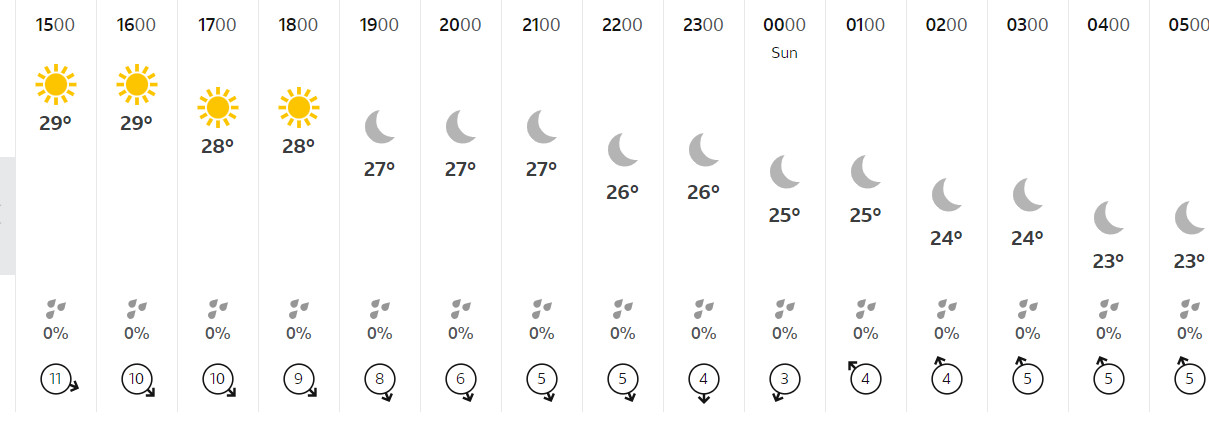

In [11]:
import pandas as pd
import re


temp = []
hour = []
rain_prob = []
wind = []

block_data = soup.find('div', class_='wr-time-slot-container__slots')

temp_parse = block_data.find_all('span', class_='wr-value--temperature--c')
for t in temp_parse:
    if t.get('class') == ['wr-value--temperature--c']: # Otherwise we'll get some additional temperatures
            temp.append(int(t.text.replace('°', '')))

rain_prob_parse = block_data.find_all('div', class_='wr-u-font-weight-500')
for rp in rain_prob_parse:
    rain_prob.append(re.search(r'\d+', rp.get_text()).group())


# Use select to match span elements with the exact class and data-unit attribute
wind_parse = block_data.find_all('span', class_='wr-value--windspeed wr-value--windspeed--mph')
# For soem reason, the wind speed is dupciated in the page source
# So we'll add every other wind speed to the list
for wind_element in wind_parse:
    wind_speed = wind_element.contents[0].strip()
    wind.append(wind_speed)
wind = wind[::2]

print(temp)
print(rain_prob)
print(wind)

#Print lengths of lists
print(len(temp))
print(len(rain_prob))
print(len(wind))

# Add the data to the DataFrame
df = pd.DataFrame({'Hour': range(15), 'Temperature': temp, 'Rain Probability': rain_prob, 'Wind': wind})


[29, 29, 28, 28, 27, 27, 27, 26, 26, 25, 25, 24, 24, 23, 23]
['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
['11', '10', '10', '9', '8', '6', '5', '5', '4', '3', '4', '4', '5', '5', '5']
15
15
15


In [9]:
df.head(15)

,Hour,Temperature,Rain Probability,Wind
0,0,29,0,11
1,1,29,0,10
2,2,28,0,10
3,3,28,0,9
4,4,27,0,8
5,5,27,0,6
6,6,27,0,5
7,7,26,0,5
8,8,26,0,4
9,9,25,0,3


# Vizualization

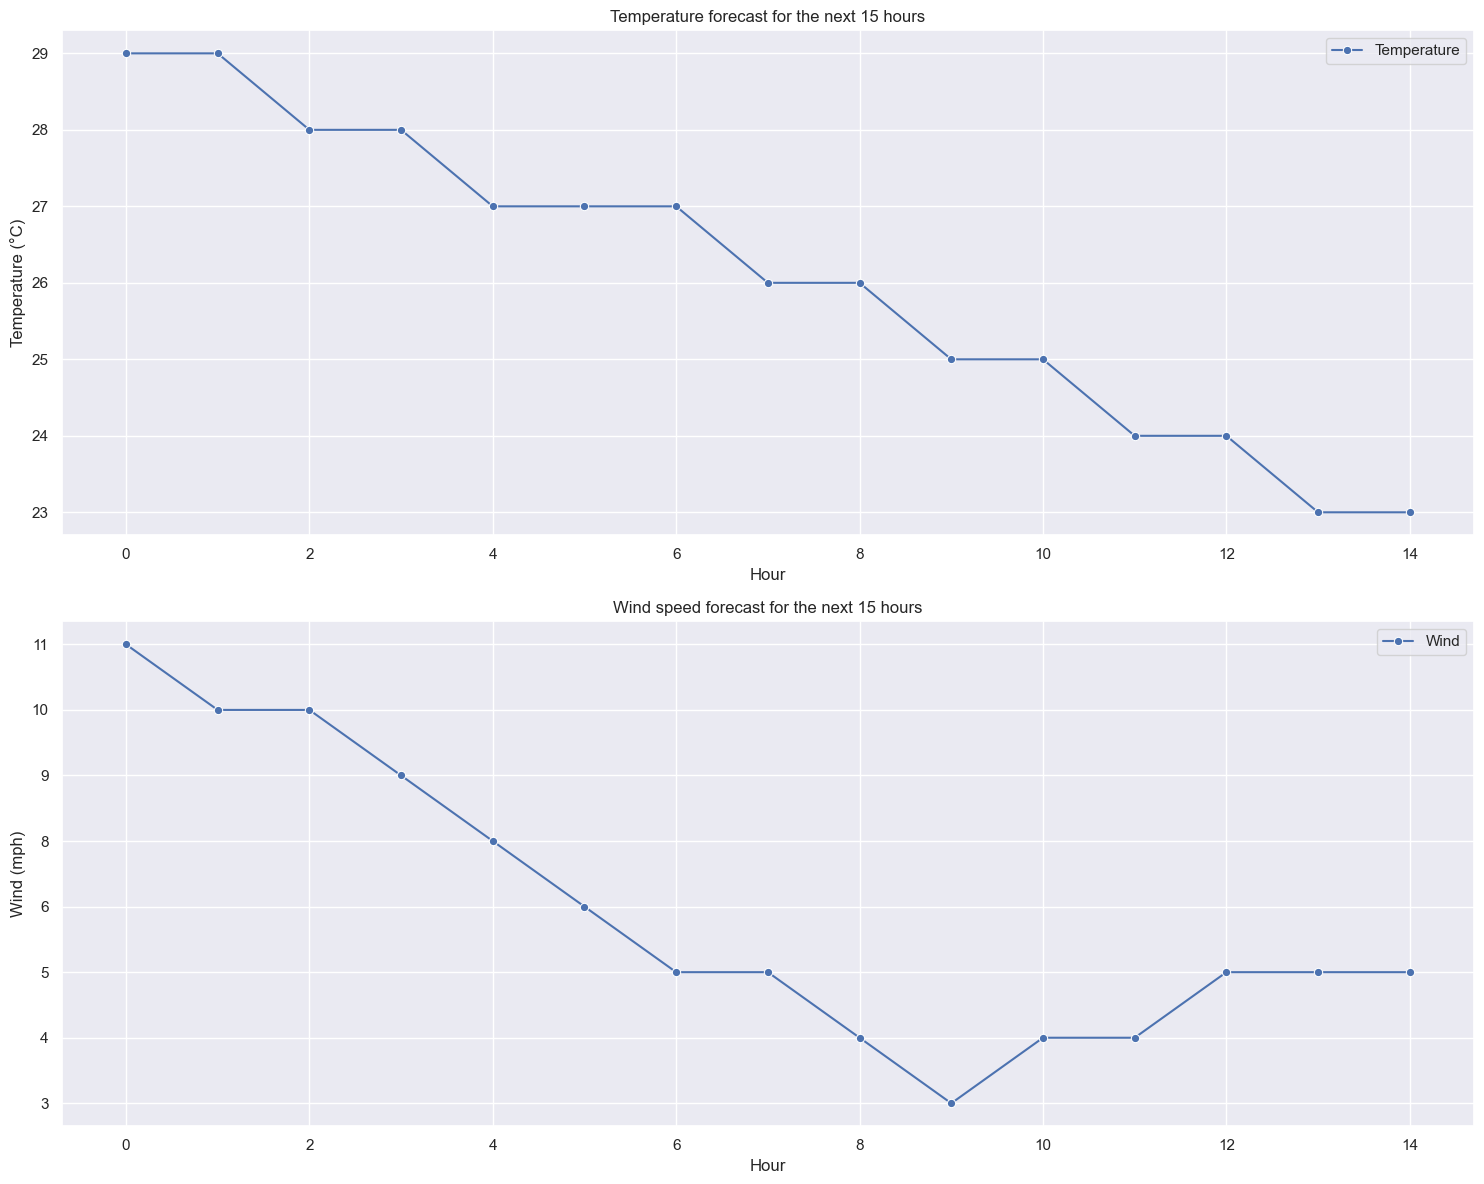

In [15]:
# Visualize temprature and wind speed
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))  # Create a grid with 2 rows and 1 column

# Plot temperature data on the first subplot
sns.lineplot(data=df, x='Hour', y='Temperature', marker='o', ax=ax1, label='Temperature')
ax1.set_ylabel('Temperature (°C)')
ax1.set_xlabel('Hour')
ax1.set_title('Temperature forecast for the next 15 hours')
ax1.legend()

# Plot wind speed data on the second subplot
sns.lineplot(data=df, x='Hour', y='Wind', marker='o', ax=ax2, label='Wind')
ax2.set_ylabel('Wind (mph)')
ax2.set_xlabel('Hour')
ax2.set_title('Wind speed forecast for the next 15 hours')
ax2.legend()

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()



As expected during the later we are in the day the lower the temperature. Wind speed steadily declines and then raises as we pass through the midnight.